In [1]:
import os
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["OMP_NUM_THREADS"] = "1"

import threadpoolctl
threadpoolctl.threadpool_limits(1, "blas")

import warnings
warnings.filterwarnings('ignore')


import gdown
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split

from rectools.dataset import Dataset
from rectools.metrics import (
    NDCG,
    AvgRecPopularity,
    Intersection,
    HitRate,
    Serendipity,
    CatalogCoverage
)
from rectools.models import PopularModel, EASEModel, SASRecModel, ImplicitALSWrapperModel
from rectools.model_selection import TimeRangeSplitter, cross_validate

from implicit.als import AlternatingLeastSquares
from catboost import CatBoostRanker, Pool


In [3]:

gdown.download(url="https://drive.google.com/uc?export=download&id=19yJocNbDNTQUDYGPHk00whKtrE2uQU9i", output="../data/interactions.csv", quiet=True)


'../data/interactions.csv'

In [4]:
interactions = pd.read_csv("../data/interactions.csv")
items = pd.read_csv("../data/items.csv")
users = pd.read_csv("../data/users.csv")

# EDA

Посмотрим на данные

In [5]:
interactions

,user_id,item_id,datetime,action
0,0,11.0,2025-05-28 07:36:48.225275608,click
1,0,73.0,2025-07-21 17:26:51.803754354,click
2,0,51.0,2025-05-05 20:20:44.838313014,click
3,0,74.0,2025-04-29 05:29:06.051551314,click
4,0,38.0,2025-04-07 14:57:00.062975580,click
...,...,...,...,...
3941443,9999,6.0,2025-07-12 18:48:25.630890802,show
3941444,9999,29.0,2025-07-12 18:48:25.630890802,show
3941445,9999,58.0,2025-07-12 18:48:25.630890802,show
3941446,9999,NaN,2025-07-05 06:57:18.551431996,show


In [6]:
interactions['action'].value_counts()

action
show     3861511
click      79937
Name: count, dtype: int64

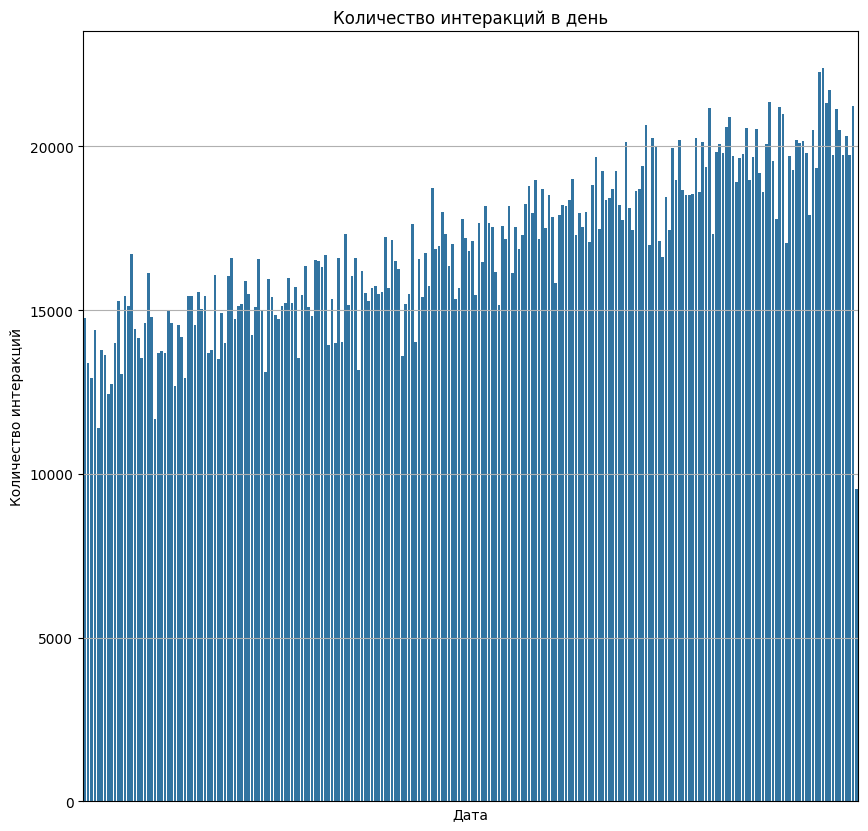

In [7]:
interactions_plot_df = interactions.copy()
interactions_plot_df["date"] = pd.to_datetime(interactions_plot_df["datetime"]).dt.date

interactions_plot_df = interactions_plot_df.groupby(["date"])[interactions_plot_df.columns[0]].count().reset_index()


plt.figure(figsize=(10,10))
sns.barplot(x='date', y='user_id', data=interactions_plot_df)
plt.xlabel('Дата')
plt.xticks([])
plt.ylabel('Количество интеракций')
plt.title('Количество интеракций в день')
plt.grid(True)
plt.show()

In [8]:
items

,item_id,genre,mean_users_score
0,0,Комедия,1.872701
1,1,Драма,4.753572
2,2,Мелодрама,3.659970
3,3,Драма,2.993292
4,4,Фантастика,0.780093
...,...,...,...
95,95,Мелодрама,2.468978
96,96,Драма,2.613664
97,97,Мелодрама,2.137705
98,98,Мелодрама,0.127096


In [9]:
items.value_counts("genre")

genre
Мелодрама     27
Драма         23
Триллер       18
Комедия       16
Фантастика    16
Name: count, dtype: int64

In [10]:
users

,user_id,sex_type
0,0,M
1,1,F
2,2,M
3,3,M
4,4,M
...,...,...
9995,9995,M
9996,9996,F
9997,9997,M
9998,9998,M


In [11]:
users.value_counts("sex_type")

sex_type
F    5005
M    4995
Name: count, dtype: int64

# Готовим модели

Разделим выборку на 2 части  по времени:


На 1 - ой части мы будем обучать модели, доступные из коробки в rectools, а также считать фичи для катбуста

На 2 - ой части мы будем стакать результаты моделей в катбуст

In [12]:
interactions["weight"] = 1.0

def split_time(datetimes, test_size=0.5):
    datetimes_sorted = datetimes.sort_values().reset_index(drop=True)
    split_date = datetimes_sorted[int(datetimes_sorted.shape[0] * test_size)]
    return datetimes_sorted[datetimes_sorted < split_date].reset_index(drop=True), datetimes_sorted[datetimes_sorted >= split_date].reset_index(drop=True)
    
first_part, second_part = split_time(interactions["datetime"])

interactions_first_period = interactions[interactions["datetime"].isin(first_part)]
interactions_second_period = interactions[interactions["datetime"].isin(second_part)]

# Для некоторых моделе нужны только позитивные взаимодействия
positive_interactions_first_period = interactions_first_period[interactions_first_period["action"] == "click"]


Инициируем рекоменедателные модели

In [13]:
dataset = Dataset.construct(
    interactions_df=positive_interactions_first_period,
)

sasrec = SASRecModel(
    session_max_len=20,
    loss="softmax",
    n_factors=64,
    n_blocks=1,
    n_heads=4,
    dropout_rate=0.2,
    lr=0.001,
    batch_size=128,
    epochs=1,
    verbose=1,
    deterministic=True,
)
ease = EASEModel()
als = ImplicitALSWrapperModel(AlternatingLeastSquares(factors=32, num_threads=7))

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Посомтрим качество базовых моделей

In [14]:
splitter = TimeRangeSplitter(
    test_size="14D",
    n_splits=5,
    filter_already_seen=True,
)

models = {
    "popular": PopularModel(),
    "ease": ease,
    "sasrec": sasrec,
    "als": als
}

metrics = {
    "HitRate@6": HitRate(k=6),
    "NDCG@6": NDCG(k=6),
    "CatalogCoverage@6": CatalogCoverage(k=6, normalize=True), # Процент объектов из каталога, которые попали в топ 6 рекомендаций хоть кому-то
    "AvgRecPopularity@6": AvgRecPopularity(k=6),  # Средняя популярность по топ 6 объектам
    "Intersection@6": Intersection(k=6),  # Процент объектов в рекомендациях, которая пересекается с топ 6
    "Serendipity@6": Serendipity(k=6),
}

K_RECS = 10

cv_results = cross_validate(
    dataset=dataset,
    splitter=splitter,
    models=models,
    metrics=metrics,
    k=K_RECS,
    filter_viewed=True,
    ref_models=["popular"],  # Модель с которой считаем пересечение
    validate_ref_models=True
)

pivot_results = (
    pd.DataFrame(cv_results["metrics"])
    .drop(columns="i_split")
    .groupby(["model"], sort=False)
    .agg(["mean"])
)
pivot_results.columns = pivot_results.columns.droplevel(1)
pivot_results


  | Name        | Type                     | Params | Mode 
-----------------------------------------------------------------
0 | torch_model | TransformerTorchBackbone | 33.1 K | train
-----------------------------------------------------------------
33.1 K    Trainable params
0         Non-trainable params
33.1 K    Total params
0.132     Total estimated model params size (MB)
23        Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 42/42 [00:06<00:00,  6.08it/s, v_num=0, train_loss=nan.0]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 42/42 [00:06<00:00,  6.08it/s, v_num=0, train_loss=nan.0]



  | Name        | Type                     | Params | Mode 
-----------------------------------------------------------------
0 | torch_model | TransformerTorchBackbone | 33.1 K | train
-----------------------------------------------------------------
33.1 K    Trainable params
0         Non-trainable params
33.1 K    Total params
0.132     Total estimated model params size (MB)
23        Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 51/51 [00:02<00:00, 22.28it/s, v_num=1, train_loss=nan.0]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 51/51 [00:02<00:00, 22.27it/s, v_num=1, train_loss=nan.0]



  | Name        | Type                     | Params | Mode 
-----------------------------------------------------------------
0 | torch_model | TransformerTorchBackbone | 33.1 K | train
-----------------------------------------------------------------
33.1 K    Trainable params
0         Non-trainable params
33.1 K    Total params
0.132     Total estimated model params size (MB)
23        Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 59/59 [00:02<00:00, 27.63it/s, v_num=2, train_loss=nan.0]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 59/59 [00:02<00:00, 27.61it/s, v_num=2, train_loss=nan.0]



  | Name        | Type                     | Params | Mode 
-----------------------------------------------------------------
0 | torch_model | TransformerTorchBackbone | 33.1 K | train
-----------------------------------------------------------------
33.1 K    Trainable params
0         Non-trainable params
33.1 K    Total params
0.132     Total estimated model params size (MB)
23        Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 64/64 [00:02<00:00, 24.43it/s, v_num=3, train_loss=nan.0]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 64/64 [00:02<00:00, 24.41it/s, v_num=3, train_loss=nan.0]



  | Name        | Type                     | Params | Mode 
-----------------------------------------------------------------
0 | torch_model | TransformerTorchBackbone | 33.1 K | train
-----------------------------------------------------------------
33.1 K    Trainable params
0         Non-trainable params
33.1 K    Total params
0.132     Total estimated model params size (MB)
23        Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 68/68 [00:02<00:00, 23.07it/s, v_num=4, train_loss=nan.0]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 68/68 [00:02<00:00, 23.06it/s, v_num=4, train_loss=nan.0]


,HitRate@6,NDCG@6,CatalogCoverage@6,AvgRecPopularity@6,Serendipity@6,Intersection@6_popular
model,,,,,,
popular,0.092792,0.015584,0.090,338.883261,0.000016,1.000000
ease,0.098184,0.016712,1.000,297.286664,0.002996,0.116155
sasrec,0.090646,0.015454,0.532,317.159452,0.001699,0.270359
als,0.092233,0.015764,0.714,303.457665,0.002916,0.053933


Обучаем наши модели на 1-ой части данных

In [15]:
%%time
sasrec.fit(dataset)
ease.fit(dataset)
als.fit(dataset)


  | Name        | Type                     | Params | Mode 
-----------------------------------------------------------------
0 | torch_model | TransformerTorchBackbone | 33.1 K | train
-----------------------------------------------------------------
33.1 K    Trainable params
0         Non-trainable params
33.1 K    Total params
0.132     Total estimated model params size (MB)
23        Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 72/72 [00:02<00:00, 26.29it/s, v_num=5, train_loss=nan.0]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 72/72 [00:02<00:00, 26.27it/s, v_num=5, train_loss=nan.0]
CPU times: user 2.41 s, sys: 738 ms, total: 3.15 s
Wall time: 3.36 s


Посмотрим на изменеие распределения als скоров. Как мы видим - оно имеет свойство смещаться, поэтому при стакинге лучше добавить нормализацию

  0%|          | 0/2 [00:00<?, ?it/s]

count    823589.000000
mean          0.012413
std           0.056747
min          -0.437861
25%          -0.010445
50%           0.008538
75%           0.034326
max           0.511830
Name: score, dtype: float64


 50%|█████     | 1/2 [00:01<00:01,  1.38s/it]

count    941119.000000
mean          0.022843
std           0.080200
min          -0.519983
25%          -0.012927
50%           0.019354
75%           0.058929
max           0.719014
Name: score, dtype: float64


100%|██████████| 2/2 [00:02<00:00,  1.43s/it]


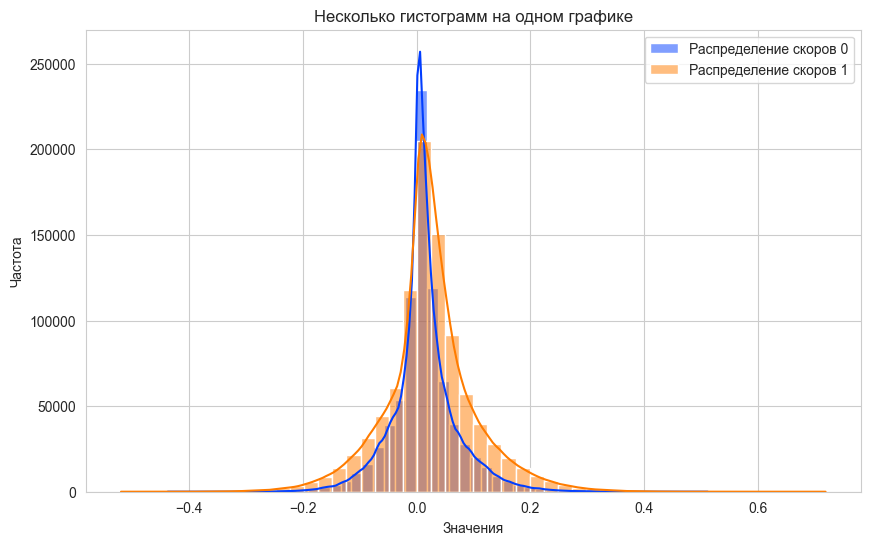

In [16]:
from tqdm import tqdm
quant_hist = 2

data = dataset.interactions.df

# создадим 2 сплита 1 день - 60 день и 1 день - 120 день
splitter = TimeRangeSplitter(
    test_size="60D",
    n_splits=quant_hist,
    filter_already_seen=True,
)

splits = splitter.get_test_fold_borders(dataset.interactions)

first_date = splits[0][0]

sns.set_style("whitegrid")
sns.set_palette("bright")

fig, ax = plt.subplots(figsize=(10, 6))
als_ = ImplicitALSWrapperModel(AlternatingLeastSquares(factors=32, num_threads=7))

recoms_list = []
for i in tqdm(range(quant_hist)):
    second_date = splits[i][1]
    # Фильтруем данные по splitter dates
    als_df = data[(pd.to_datetime(data['datetime']) >= pd.to_datetime(first_date)) & (pd.to_datetime(data['datetime']) <= pd.to_datetime(second_date))]
    als_dataset =  Dataset.construct(
    interactions_df=als_df,
    )
    als_model = als_.fit(als_dataset)
    recoms = als_model.recommend(users=als_dataset.user_id_map.external_ids, dataset=als_dataset, filter_viewed=True, k=100)
    print(recoms["score"].describe())
    recoms_list.append(recoms["score"])

    sns.histplot(recoms["score"], ax=ax, label=f'Распределение скоров {i}',  kde=True, bins=50) # Добавлен kde=True для сглаживания



ax.set_title('Несколько гистограмм на одном графике')
ax.set_xlabel('Значения')
ax.set_ylabel('Частота')
ax.legend()

# Отображаем график
plt.show()


In [17]:
# Скорим базовые модели
recom_sasrec = sasrec.recommend(users=dataset.user_id_map.external_ids, dataset=dataset, filter_viewed=True, k=100).drop(columns=['rank']).rename(columns={"score": "sasrec_score"})
recom_ease = ease.recommend(users=dataset.user_id_map.external_ids, dataset=dataset, filter_viewed=True, k=100).drop(columns=['rank']).rename(columns={"score": "ease_score"})
recom_als = als.recommend(users=dataset.user_id_map.external_ids, dataset=dataset, filter_viewed=True, k=100).drop(columns=['rank']).rename(columns={"score": "als_score"})

# Добавим нормировку
def normalize(data):
    return (data - data.mean()) / data.std()

recom_sasrec["sasrec_score"] = normalize(recom_sasrec["sasrec_score"])
recom_ease["ease_score"] = normalize(recom_ease["ease_score"])
recom_als["als_score"] = normalize(recom_als["als_score"])

# Обучаемся - на логах
target_df = interactions_second_period[["user_id", "item_id"]].drop_duplicates()
target_df["target"] = interactions_second_period["action"].map({"click": 1, "show": 0})


all_features = pd.merge(users["user_id"], items["item_id"], how="cross")
all_features = all_features.merge(target_df, on=["user_id", "item_id"], how="left")
all_features = all_features.fillna(0)

all_features = all_features.merge(users, on=["user_id"], how="left")
all_features = all_features.merge(items, on=["item_id"], how="left")
all_features = all_features.merge(recom_sasrec, on=["user_id", "item_id"], how="left")
all_features = all_features.merge(recom_ease, on=["user_id", "item_id"], how="left")
all_features = all_features.merge(recom_als, on=["user_id", "item_id"], how="left")

all_features = all_features.fillna(0)

all_features

,user_id,item_id,target,sex_type,genre,mean_users_score,sasrec_score,ease_score,als_score
0,0,0,0.0,M,Комедия,1.872701,-0.933588,0.954731,0.544400
1,0,1,0.0,M,Драма,4.753572,0.304198,1.720800,0.397345
2,0,2,0.0,M,Мелодрама,3.659970,-0.363093,2.252170,0.878526
3,0,3,0.0,M,Драма,2.993292,-1.258670,-0.065691,0.208447
4,0,4,0.0,M,Фантастика,0.780093,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...
999995,9999,95,0.0,M,Мелодрама,2.468978,-0.172637,0.035745,0.851940
999996,9999,96,0.0,M,Драма,2.613664,0.338299,0.556249,1.503953
999997,9999,97,0.0,M,Мелодрама,2.137705,0.501455,-0.904800,-0.206815
999998,9999,98,1.0,M,Мелодрама,0.127096,0.032146,0.408203,1.190029


In [18]:
# Разделяем пользователей на тренировочную и валидационную выборки - важно что бы пользователь полностью попал либо в трейн, kb,j d dfkblfwb.
train_users, val_users = train_test_split(all_features["user_id"].drop_duplicates(), test_size=0.25, random_state=42)

data_train = all_features[all_features["user_id"].isin(train_users)].sort_values("user_id")
data_val = all_features[all_features["user_id"].isin(val_users)].sort_values("user_id")

X_train = data_train.drop(columns="target")
X_val = data_val.drop(columns="target")
y_train = data_train["target"]
y_val = data_val["target"]

In [19]:
train_pool = Pool(data=X_train.drop(columns=["user_id", "item_id"]), label=y_train, group_id=X_train["user_id"], cat_features=['sex_type', 'genre'])
val_pool = Pool(data=X_val.drop(columns=["user_id", "item_id"]), label=y_val, group_id=X_val["user_id"], cat_features=['sex_type', 'genre'])


model = CatBoostRanker(
    iterations=100,             
    learning_rate=0.1,          
    depth=6,                    
    early_stopping_rounds=3
)

model.fit(train_pool, eval_set=val_pool) 


Groupwise loss function. OneHotMaxSize set to 10
0:	test: 0.1532386	best: 0.1532386 (0)	total: 275ms	remaining: 27.3s
1:	test: 0.1881653	best: 0.1881653 (1)	total: 499ms	remaining: 24.4s
2:	test: 0.1817699	best: 0.1881653 (1)	total: 729ms	remaining: 23.6s
3:	test: 0.2203156	best: 0.2203156 (3)	total: 926ms	remaining: 22.2s
4:	test: 0.2521549	best: 0.2521549 (4)	total: 1.13s	remaining: 21.6s
5:	test: 0.2595290	best: 0.2595290 (5)	total: 1.35s	remaining: 21.2s
6:	test: 0.2710852	best: 0.2710852 (6)	total: 1.64s	remaining: 21.8s
7:	test: 0.2799290	best: 0.2799290 (7)	total: 1.85s	remaining: 21.3s
8:	test: 0.2856277	best: 0.2856277 (8)	total: 2.06s	remaining: 20.8s
9:	test: 0.2849212	best: 0.2856277 (8)	total: 2.45s	remaining: 22s
10:	test: 0.2871778	best: 0.2871778 (10)	total: 2.67s	remaining: 21.6s
11:	test: 0.2888405	best: 0.2888405 (11)	total: 2.89s	remaining: 21.2s
12:	test: 0.2863863	best: 0.2888405 (11)	total: 3.11s	remaining: 20.8s
13:	test: 0.2870792	best: 0.2888405 (11)	total: 3.

Проанализируем логику работы модели

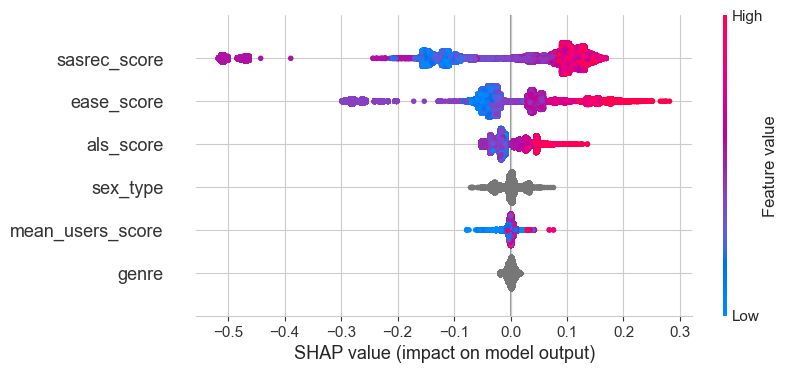

In [20]:
import shap

# Создайте экземпляр SHAP
explainer = shap.TreeExplainer(model)

# Получите SHAP-значения для данных
shap_values = explainer(X_val.drop(columns=["user_id", "item_id"]))

# Постройте SHAP-график
shap.plots.beeswarm(shap_values)


Посчитаем истинный NDCG

In [21]:
from sklearn.metrics import ndcg_score
import numpy as np
from tqdm import tqdm

true_relevance = pd.read_csv("../data/true_relevance.csv")

val_scores = X_val[["user_id", "item_id"]]
val_scores['prediction'] = model.predict(val_pool)

all_scores = val_scores.merge(true_relevance, on=["user_id", "item_id"])

all_ndcg = []

for user in tqdm(all_scores["user_id"].unique()):
    if all_scores[all_scores["user_id"] == user].shape[0] > 1:
        sc = ndcg_score(all_scores.loc[all_scores["user_id"] == user, "true_relevance"].to_numpy().reshape(1, -1), all_scores.loc[all_scores["user_id"] == user, "prediction"].to_numpy().reshape(1, -1), k=6)
        all_ndcg.append(sc)

print(np.mean(all_ndcg))

100%|██████████| 2500/2500 [00:01<00:00, 1680.69it/s]

0.688605115390416
